# Data Cleaning and EDA Notebook
---

# Import Libraries

In [1]:
#pip install matplotlib-venn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from collections import Counter

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

Reading my new and improved data set with reddit and chatgpt responses

# Data Cleaning

In [3]:
data = pd.read_csv("../data/reddit_chatgpt_full_data.csv")
data.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,title,selftext,subreddit,comments,created_utc,chatgpt_response
0,9,9,9,How can I use backlinks in mdbook?,I found this crate called [mdbook-backlinks](h...,techsupport,NaN,1.695140e+09,NaN
1,10,10,10,Pc not booting up again after reinstalling gpu.,Vga light is lit up on motherboard. No pocture...,techsupport,NaN,1.695151e+09,It sounds like you may have damage to either t...
2,14,14,14,I think my mums phone has been attacked with a...,Hi I believe my mum has recently installed som...,techsupport,Factory reset.,1.695151e+09,The easiest way to stop this is to try and res...
3,15,15,15,how to stop constant formatting?,When I'm downloading something onto an externa...,techsupport,NaN,1.695150e+09,NaN
4,24,24,24,Help with laptop to tv,When I connect my MacBook Air to the TV with H...,techsupport,is it set to mirror desktop or as 2nd monitor?...,1.695149e+09,NaN


In [4]:
data.shape

(5127, 9)

Wanted to drop the random columns that were added as I am not really sure where they came from

In [5]:
data = data.drop(columns=['Unnamed: 0.2','Unnamed: 0.1','Unnamed: 0'])
data.head()

,title,selftext,subreddit,comments,created_utc,chatgpt_response
0,How can I use backlinks in mdbook?,I found this crate called [mdbook-backlinks](h...,techsupport,NaN,1.695140e+09,NaN
1,Pc not booting up again after reinstalling gpu.,Vga light is lit up on motherboard. No pocture...,techsupport,NaN,1.695151e+09,It sounds like you may have damage to either t...
2,I think my mums phone has been attacked with a...,Hi I believe my mum has recently installed som...,techsupport,Factory reset.,1.695151e+09,The easiest way to stop this is to try and res...
3,how to stop constant formatting?,When I'm downloading something onto an externa...,techsupport,NaN,1.695150e+09,NaN
4,Help with laptop to tv,When I connect my MacBook Air to the TV with H...,techsupport,is it set to mirror desktop or as 2nd monitor?...,1.695149e+09,NaN


In [6]:
data.isnull().sum()

title                  0
selftext             153
subreddit              2
comments             656
created_utc            4
chatgpt_response    1206
dtype: int64

I decided that it worth more my time to just drop the 1206 empty rows then pull entirely new rows from reddit to ask questions on. For some reason when I reran the api calls on the missing rows they still got no response from chatgpt. We will have to work with what we have

In [7]:
data = data.dropna()

In [8]:
data.shape

(3422, 6)

In [9]:
data = data.rename(columns={'selftext': 'reddit_question', 'comments': 'human_response'})

In [10]:
data.dtypes

title                object
reddit_question      object
subreddit            object
human_response       object
created_utc         float64
chatgpt_response     object
dtype: object

In [11]:
data.head()

,title,reddit_question,subreddit,human_response,created_utc,chatgpt_response
2,I think my mums phone has been attacked with a...,Hi I believe my mum has recently installed som...,techsupport,Factory reset.,1.695151e+09,The easiest way to stop this is to try and res...
8,PC acting on its own,"Hi all, last night I had a few strange issues ...",techsupport,If you suspect you may have malware on your co...,1.695146e+09,There could be a few reasons why your PC is ex...
16,Does installing windows 10 through iso affect ...,I don't have a disc or usb to create a bootabl...,techsupport,Nope. Windows will mount the ISO file as if it...,1.695141e+09,There is no difference between using a disc or...
18,Only my roommates PC and phone will not work p...,"Only certain websites work for him on PC, like...",techsupport,Do you have a newer computer and phone compare...,1.695141e+09,It's possible that your computer is not suppor...
21,"PC is stuck on BIOS screen, cannot press any k...",I built my brother a pc a few days ago from ol...,techsupport,I would try to pull the cmos battery and reset...,1.695140e+09,Thanks


-------
# EDA

From all the work we did it seems like that statistic questions did not play nice with the chatgpt api as I assume it maybe had a lot of math in the questions. Probably similar with tech support as there was probably a little math involved.

In [12]:
data['subreddit'].value_counts()

AskCulinary      907
askphilosophy    846
AskAcademia      763
techsupport      524
AskStatistics    382
Name: subreddit, dtype: int64

Data describe is pretty useless here

In [13]:
data.describe()

,created_utc
count,3.422000e+03
mean,1.693324e+09
std,1.626192e+06
min,1.688916e+09
25%,1.692297e+09
50%,1.693677e+09
75%,1.694793e+09
max,1.695157e+09


I want to get a sense of commanality of words between the reddit questions, the human generated answers, the chatgpt answers to see early on what way we think our model will lean and if it might be tricked into not knowing the chatgpt response is not human made.

I defined a function to count the most popular words from the three columns not including stopwords where I will then put in a venn diagram to see what they have in common and how much

In [14]:
def word_frequency(column,top_n,exclude_stopwords=False):
    words = ' '.join(column).split()
    if exclude_stopwords:
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word.lower() not in stop_words]
    word_freq = Counter(words)
    top_words = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:top_n])
    top_words_df = pd.DataFrame(top_words.items(), columns=['Word', 'Frequency'])
    return top_words_df

---
This is WITH StopWords

In [15]:
word_frequency(data['reddit_question'],10)

,Word,Frequency
0,the,14094
1,I,12867
2,to,11258
3,and,9572
4,a,9498
5,of,7220
6,in,5589
7,is,5131
8,that,4514
9,it,4449


In [16]:
word_frequency(data['human_response'],10)

,Word,Frequency
0,the,10147
1,to,8887
2,a,6721
3,of,6149
4,and,5910
5,you,4960
6,is,4075
7,that,3668
8,in,3363
9,it,2423


In [17]:
word_frequency(data['chatgpt_response'],10)

,Word,Frequency
0,the,4728
1,to,4008
2,a,2942
3,is,2840
4,and,2647
5,of,2550
6,in,1591
7,that,1590
8,you,1516
9,it,1321


As expected majority of the commanality is the stop words themselves


---
This is WITHOUT StopWords

In [18]:
word_frequency(data['reddit_question'],10,True)

,Word,Frequency
0,would,1529
1,I'm,1398
2,like,1284
3,know,918
4,one,887
5,get,795
6,I’m,724
7,also,672
8,I've,660
9,want,647


In [19]:
word_frequency(data['human_response'],10,True)

,Word,Frequency
0,would,852
1,like,795
2,questions,758
3,Please,715
4,make,709
5,see,641
6,get,588
7,one,577
8,think,504
9,read,461


In [20]:
word_frequency(data['chatgpt_response'],10,True)

,Word,Frequency
0,may,441
1,would,419
2,could,338
3,make,258
4,like,242
5,use,235
6,"Yes,",222
7,answer,216
8,way,215
9,"However,",213


Taking a rough look a bove we can see from the top 10 words that would, like, make, get, use, one are common amongst the three columns

---
What I will do below is take the top 100 words from each column and put them in a venn diagram

In [21]:
top_reddit = word_frequency(data['reddit_question'],100,True)
top_human = word_frequency(data['human_response'],100,True)
top_chatgpt = word_frequency(data['chatgpt_response'],100,True)

In [22]:
reddit_words_only = top_reddit['Word'].tolist()
human_words_only = top_human['Word'].tolist()
chatgpt_words_only = top_chatgpt['Word'].tolist()

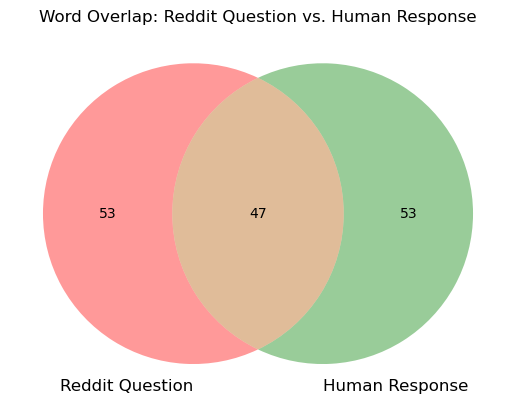

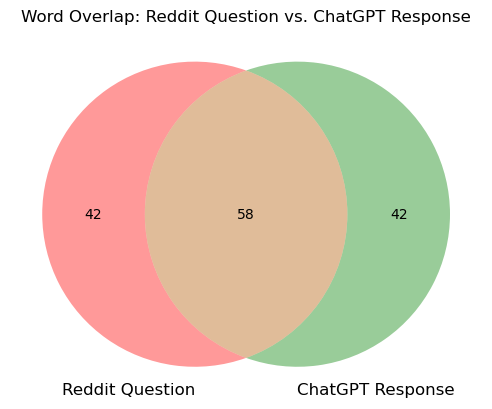

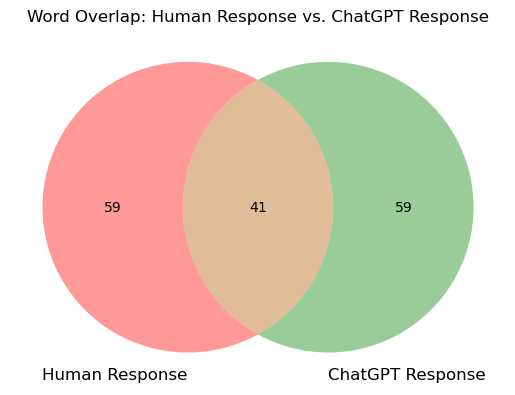

In [23]:
venn2([set(reddit_words_only), set(human_words_only)], ('Reddit Question', 'Human Response'))
plt.title('Word Overlap: Reddit Question vs. Human Response')
plt.show()

venn2([set(reddit_words_only), set(chatgpt_words_only)], ('Reddit Question', 'ChatGPT Response'))
plt.title('Word Overlap: Reddit Question vs. ChatGPT Response')
plt.show()

venn2([set(human_words_only), set(chatgpt_words_only)], ('Human Response', 'ChatGPT Response'))
plt.title('Word Overlap: Human Response vs. ChatGPT Response')
plt.show()

What you see above is something that actually sort of surprised me. We see high overlap between the chatgpt response and the reddit question which leads me to believe that our model may think that that majority of chatgpt response may be human generated. We dont see as much overlap between reddit questions and human response but still a decent amount. The lowest amount of overlap is between human response and chatgpt response. What this leads me to believe is that perhaps our model may get wrong what is human and what is AI but it will be definitive in deciding one way or another with strong conviction. Too soon to tell but perhaps I may be right

Just to make sure what I want to do is increase my word list to top 1000 to see if we can different behavior

In [24]:
top_reddit = word_frequency(data['reddit_question'],1000,True)
top_human = word_frequency(data['human_response'],1000,True)
top_chatgpt = word_frequency(data['chatgpt_response'],1000,True)

reddit_words_only = top_reddit['Word'].tolist()
human_words_only = top_human['Word'].tolist()
chatgpt_words_only = top_chatgpt['Word'].tolist()

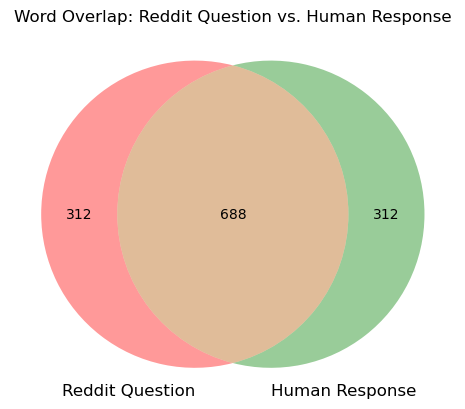

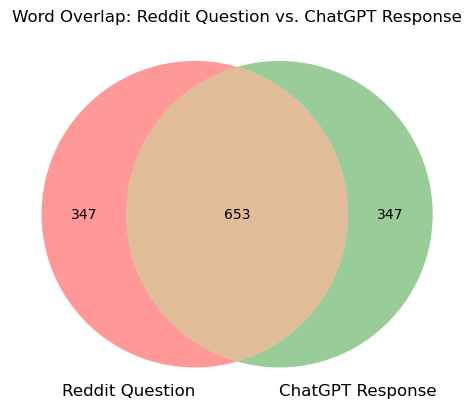

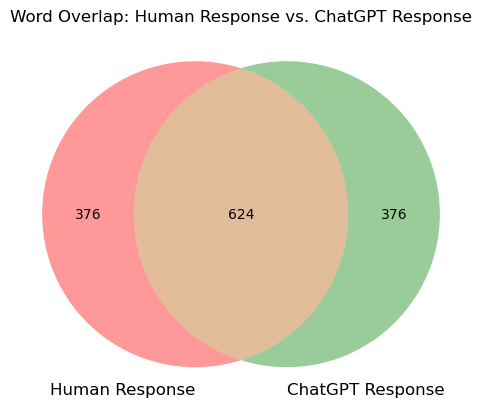

In [25]:
venn2([set(reddit_words_only), set(human_words_only)], ('Reddit Question', 'Human Response'))
plt.title('Word Overlap: Reddit Question vs. Human Response')
plt.show()

venn2([set(reddit_words_only), set(chatgpt_words_only)], ('Reddit Question', 'ChatGPT Response'))
plt.title('Word Overlap: Reddit Question vs. ChatGPT Response')
plt.show()

venn2([set(human_words_only), set(chatgpt_words_only)], ('Human Response', 'ChatGPT Response'))
plt.title('Word Overlap: Human Response vs. ChatGPT Response')
plt.show()

Looks like as we increase the word list we actually get a lot more overlap amongst the responses and the questions being asked. Specifically significantly increase overlap between human response and reddit questions. More so in fact that chatgpt response and reddit questions. This sort of makes sense to me as sometimes in questions we may use slang words and use them as well in our response whereas chatgpt most likely woulndt incorporate them. 

I want to increase my word list to 5000 to see how behavior changes

In [26]:
top_reddit = word_frequency(data['reddit_question'],5000,True)
top_human = word_frequency(data['human_response'],5000,True)
top_chatgpt = word_frequency(data['chatgpt_response'],5000,True)

reddit_words_only = top_reddit['Word'].tolist()
human_words_only = top_human['Word'].tolist()
chatgpt_words_only = top_chatgpt['Word'].tolist()

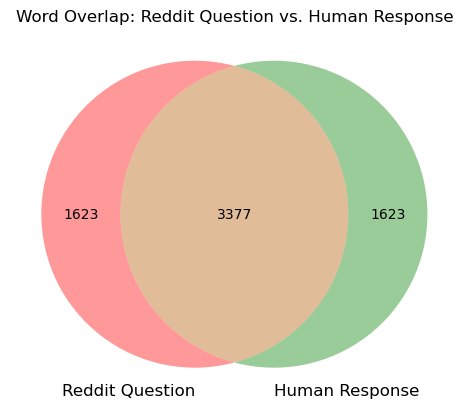

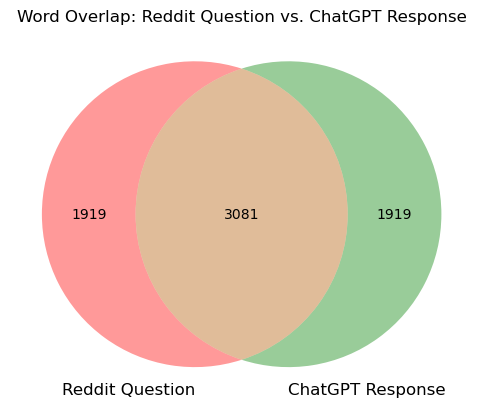

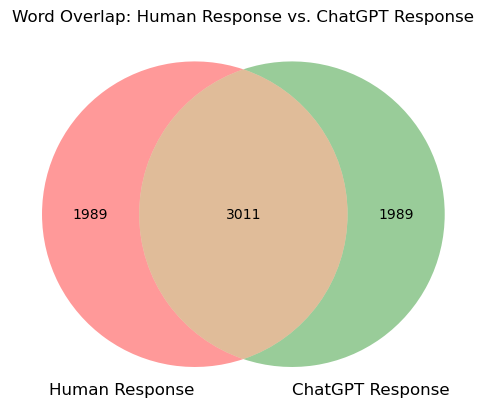

In [27]:
venn2([set(reddit_words_only), set(human_words_only)], ('Reddit Question', 'Human Response'))
plt.title('Word Overlap: Reddit Question vs. Human Response')
plt.show()

venn2([set(reddit_words_only), set(chatgpt_words_only)], ('Reddit Question', 'ChatGPT Response'))
plt.title('Word Overlap: Reddit Question vs. ChatGPT Response')
plt.show()

venn2([set(human_words_only), set(chatgpt_words_only)], ('Human Response', 'ChatGPT Response'))
plt.title('Word Overlap: Human Response vs. ChatGPT Response')
plt.show()

Ok I think we are getting more of the same here. As we increase size we increase in overlap between human answer and reddit question. And we increase in size we see decreased percentage of overlap between chatgpt and reddit questions.

Ultimately this will come down to how we vectorize our word list, how much weight we put into frequency and other variables we still need to investigate into our model to dictate how effective we can distinguish chatgpt and human answers

### Things to look at
#### Unique words and overall vocab list
#### n-gram analysis
#### text preprocessing: lowercasing, removing special characters, stemming and lemmatization
#### Text Visualiationz

The next thing I want to look at is sentence complexity and structure to get a sense of do human sentence tend to be longer since they may be runoff, do we use more long sentences or short sentences when we speak. How about the ai? is there a pattern between using short and long. Basically for lack of better description to understand languge/verbal "fluidity".

In [28]:
data['human_sentence_length'] = data['human_response'].apply(lambda x: len(str(x).split()))
data['chatgpt_sentence_length'] = data['chatgpt_response'].apply(lambda x: len(str(x).split()))

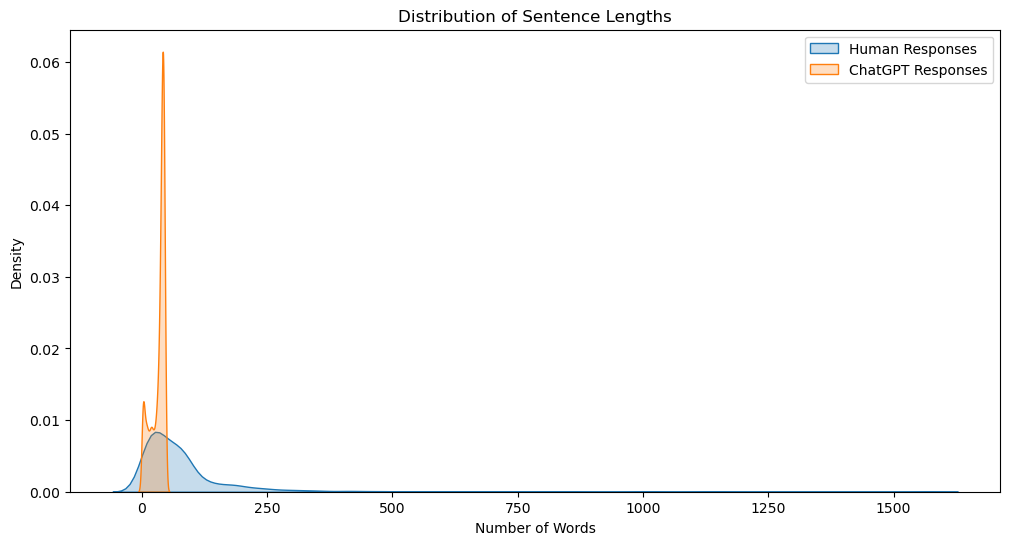

In [29]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data['human_sentence_length'], label='Human Responses', shade=True)
sns.kdeplot(data['chatgpt_sentence_length'], label='ChatGPT Responses', shade=True)
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Density')
plt.legend()
plt.show()

The above is really shocking. For as large as OpenAI LLM is the sentence variety is suprisingly low compared to human variety. I believe human was going to be a lot more but I guess I underestimated just how long us humans can go speaking without any pauses, punctuation or end of sentencing. 

What this graph above is demonstrating that the number of words in a human sentence far exceeds the number of words in a chatgpt sentence. Definitely something to consider when building our models

---

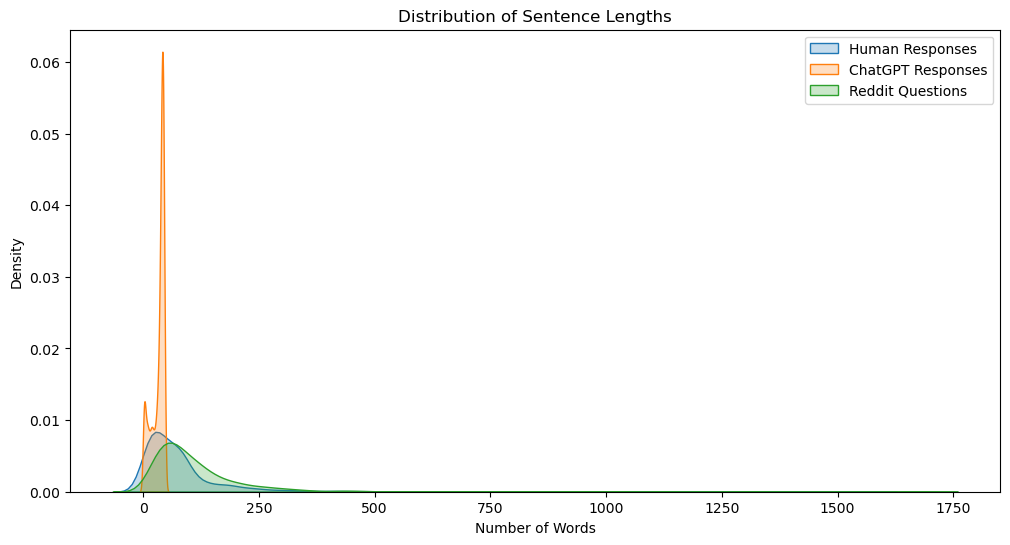

In [30]:
data['reddit_sentence_length'] = data['reddit_question'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 6))
sns.kdeplot(data['human_sentence_length'], label='Human Responses', shade=True)
sns.kdeplot(data['chatgpt_sentence_length'], label='ChatGPT Responses', shade=True)
sns.kdeplot(data['reddit_sentence_length'], label='Reddit Questions', shade=True)
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Density')
plt.legend()
plt.show()

I wanted to display the chart above again but overlayed with reddit questions sentence distribution. As you can see obviously huge correlation with human generated responses. Not sure if my model will train and make that link with reddit question sentence distribution with that of human answers. I will have to revist this potentially.

---
What I would like to do next here is count the amount of clauses to a) look at the average amount of clauses in the sentences from all columns and b) see if there is a huge correlation like above between human and reddit

In [31]:
def count_clauses(sentence):
    
    conjunctions = ["and", "but", "or", "nor", "for", "so", "yet"]
    count = sum([sentence.split().count(conj) for conj in conjunctions]) + sentence.count(',')
    return count + 1

In [32]:
data['reddit_clauses'] = data['reddit_question'].apply(count_clauses)
data['human_clauses'] = data['human_response'].apply(count_clauses)
data['chatgpt_clauses'] = data['chatgpt_response'].apply(count_clauses)

print(f"Average number of clauses in reddit questions: {data['reddit_clauses'].mean()}")
print(f"Average number of clauses in human responses: {data['human_clauses'].mean()}")
print(f"Average number of clauses in chatGPT responses: {data['chatgpt_clauses'].mean()}")

Average number of clauses in reddit questions: 11.091174751607248
Average number of clauses in human responses: 8.26709526592636
Average number of clauses in chatGPT responses: 3.8664523670368207





---
The average number of clases is still about 3 more uses higher in reddit than in human responses but still significantly higher than chatgpt. Which makes sense as we tend to speak with an overuse of conjuctions when not really needed. I think it is starting to become more and more apparent that chatgpt responses are much cleaner, efficient, grammatically correct, and use a variety of words more so than human generated.

The next peice I want to look at is uniqueness of words from the columns. Specifically the ratio of unique words against the total overall word list. Not simply just the numerical total amount. 

In [33]:
def unique_word_ratio(text):
    words = str(text).split()
    return len(set(words)) / len(words) if words else 0

In [34]:
data['reddit_unique_word_ratio'] = data['reddit_question'].apply(unique_word_ratio)
data['human_unique_word_ratio'] = data['human_response'].apply(unique_word_ratio)
data['chatgpt_unique_word_ratio'] = data['chatgpt_response'].apply(unique_word_ratio)

print(f"Average unique word ratio in reddit questions: {data['reddit_unique_word_ratio'].mean()}")
print(f"Average unique word ratio in human responses: {data['human_unique_word_ratio'].mean()}")
print(f"Average unique word ratio in chatGPT responses: {data['chatgpt_unique_word_ratio'].mean()}")

Average unique word ratio in reddit questions: 0.7699014300006813
Average unique word ratio in human responses: 0.8369412439804145
Average unique word ratio in chatGPT responses: 0.8692428037275195


---
The unique word ratio above is calculated by dividing the number of unique words in a response by total number of words in that response. The number displayed is the mean of that ratio done on each column of importance.

What we learn here is that the reddit questions themselves have the least amount of unique word diversity whereas the chatgpt response has the highest amount of diversity. This makes sense for a few reasons: a) chatgpt is trained on a vast model of english words so it knows when and how to use certain words and is able to recall the most optimal word in a sentence a lot more often than a human would and b) despite english being an expansive language us human rarely use it to its full extent. Communicative language needs far fewer words to convey the type of messages we use on a daily basis as reddit is a exhibit of.

---

Moving on, I want look at n gram usage to see what we can learn there. I dont have any preconceived notion before going into this analysis and im interested to see if we learn anything surprising.

I defined a function to get the n grams per response and will apply it in a loop to each column of significance. After doing so I will take the value counts of the top 20 in 2,3,4,5 and 6 n grams

In [35]:
def get_ngrams(text, n):
    tokens = nltk.word_tokenize(text)
    ngrams = list(nltk.ngrams(tokens, n))
    return [" ".join(gram) for gram in ngrams]

In [36]:
ngram_lengths = [2, 3, 4, 5, 6]

for n in ngram_lengths:
    reddit_ngrams = data['reddit_question'].apply(lambda x: get_ngrams(str(x), n)).explode().value_counts()
    human_ngrams = data['human_response'].apply(lambda x: get_ngrams(str(x), n)).explode().value_counts()
    chatgpt_ngrams = data['chatgpt_response'].apply(lambda x: get_ngrams(str(x), n)).explode().value_counts()
    
    print(f"Top 20 {n}-grams in Reddit Questions:\n", reddit_ngrams.head(20))
    print('-'*50)
    print(f"Top 20 {n}-grams in Human Responses:\n", human_ngrams.head(20))
    print('-'*50)
    print(f"Top 20 {n}-grams in ChatGPT Responses:\n", chatgpt_ngrams.head(20))
    print('-'*50)
    print('-'*130)
    print('-'*130)
    print('-'*130)
    print('-'*130)

Top 20 2-grams in Reddit Questions:
 . I       3500
, I       1620
, and     1581
I 'm      1417
, but     1406
I have    1308
in the    1251
I ’       1149
I am      1137
of the    1135
and I      886
) .        762
but I      751
’ m        747
’ t        681
I 've      670
. The      649
to be      636
? I        600
’ s        592
Name: reddit_question, dtype: int64
--------------------------------------------------
Top 20 2-grams in Human Responses:
 ] (         1420
, and       1411
https :     1320
( https     1002
of the       972
. If         922
* *          920
. *          907
if you       879
, but        834
) .          808
If you       803
in the       787
you have     768
. I          729
. Please     708
, or         566
it 's        549
to be        539
. The        526
Name: human_response, dtype: int64
--------------------------------------------------
Top 20 2-grams in ChatGPT Responses:
 , and        457
of the       454
, it         437
it is        411
in the  

After looking n-grams I have a lot of thoughts and a changed opnion on how things will procede from here.

Firstly, at the 2 and 3 n-gram level, its very hard to consider any of the results from the human answers as unfortunately it it looks like we picked up a lot of junk material. I might have to look at n gram analysis again the my modeling notebook when I begin the pre-processing since there's nothing to learn from it right now.

Secondly, even at the 4,5, and 6 gram level when it comes to the human answers it seems that we picked up a lot of bot response. I am not really sure what went wrong here, if the top responses were indeed bots, if the api call missed the important text from the top comments and returned bot material, or if there is some sort of text that is added to each human answer that says "please contact the moderators. Nonetheless it is kind of dissapointing since I am $20 into this project and I cant really spend any more time attempting to pull more reddit data and pose the question to chatgpt. I am not sure if due to the integrity of my data if it will create for a bad model but despite all of that we move.

Lastly, the n-grams for the chatgpt show that they have a wide variety of language use. If we look at the frequencies in the top 20 for reddit and human text we see numbers in the 400-1000 range. If we look at the top frequencies for the chatgpt repsonses we see it ranges from 14-500. A HUGE disparity in vocabulary and sentence structure variety. Chatgpt is definitely putting its vast LLM to use here which is important information to consider when building the model. 

There really isnt a need to look at n-gram ratio and mean here due the disaprity visualized in the data above.

What I want to here to try elimiante the dissapointment of the n gram results produced by reddit is try to the next 20 instead of top 20 to avoid the automated text to see if we can bring down the frequency and see any correlation between human answers and chatgpt answers.

In [37]:
ngram_lengths = [2, 3, 4, 5, 6]

for n in ngram_lengths:
    reddit_ngrams = data['reddit_question'].apply(lambda x: get_ngrams(str(x), n)).explode().value_counts()
    human_ngrams = data['human_response'].apply(lambda x: get_ngrams(str(x), n)).explode().value_counts()
    chatgpt_ngrams = data['chatgpt_response'].apply(lambda x: get_ngrams(str(x), n)).explode().value_counts()
    
    print(f"Top 40-60 {n}-grams in Reddit Questions:\n", reddit_ngrams.iloc[40:60])
    print('-'*50)
    print(f"Top 40-60 {n}-grams in Human Responses:\n", human_ngrams.iloc[40:60])
    print('-'*50)
    print(f"Top 20 {n}-grams in ChatGPT Responses:\n", chatgpt_ngrams.head(20))
    print('-'*50)
    print('-'*130)
    print('-'*130)
    print('-'*130)
    print('-'*130)

Top 40-60 2-grams in Reddit Questions:
 to do       399
for the     398
so I        389
it is       385
, so        383
. But       380
) ,         380
I would     365
with the    359
. So        356
in my       355
if I        355
. My        354
it .        354
’ ve        350
, it        346
as a        345
is the      339
, or        335
of my       330
Name: reddit_question, dtype: int64
--------------------------------------------------
Top 40-60 2-grams in Human Responses:
 automatically .            412
bot ,                      412
a bot                      412
any questions              412
Please [                   412
[ contact                  412
the moderators             412
moderators of              412
subreddit ]                412
( /message/compose/        412
/message/compose/ ?        412
) if                       412
performed automatically    412
or concerns                412
was performed              412
, you                      406
is a              

It is just as dissapointing....lets just move on.

Next I want to take a look at the use of special words usage and formatting usage as well. My belief is that reddit questions and human answers will have a lot of special word usage and that chatgpt will have much more use of puncation and proper formatting.

I am going to define a function to count the two and then we will compare the columns and make adjustments as needed. These are all the slang words I could come up with that would be relevant which isnt perfect as Im sure there is more. However I feel like this would be sufficient.

In [38]:
slang_words = ['haha','hahaha','hahahaha','lol', 'lmao', 'omg', 'bro', 'rofl','ama','bf','gf','ehh','mmm','tldr','op','dae','DAE',
               'imo','IMO','psa','til']
punctuations = list('!"#$%&\'()*+,-./:;<=>?@[\\]_^`{|}~')

In [41]:
def slang_count(text):
    return sum([str(text).lower().split().count(word) for word in slang_words])

def punctuation_count(text):
    return sum([str(text).count(p) for p in punctuations])

In [46]:
data['reddit_slang_count'] = data['reddit_question'].apply(slang_count)
data['human_slang_count'] = data['human_response'].apply(slang_count)
data['chatgpt_slang_count'] = data['chatgpt_response'].apply(slang_count)

data['reddit_punctuation_count'] = data['reddit_question'].apply(punctuation_count)
data['human_punctuation_count'] = data['human_response'].apply(punctuation_count)
data['chatgpt_punctuation_count'] = data['chatgpt_response'].apply(punctuation_count)

print(f"Average slang count in reddit questions: {data['reddit_slang_count'].mean()}")
print(f"Average slang count in human responses: {data['human_slang_count'].mean()}")
print(f"Average slang count in ChatGPT responses: {data['chatgpt_slang_count'].mean()}")
print('-'*70)
print(f"Average punctuation count in reddit questions: {data['reddit_punctuation_count'].mean()}")
print(f"Average punctuation count in human responses: {data['human_punctuation_count'].mean()}")
print(f"Average punctuation count in ChatGPT responses: {data['chatgpt_punctuation_count'].mean()}")
print('-'*70)

Average slang count in reddit questions: 0.007890122735242549
Average slang count in human responses: 0.010227936879018119
Average slang count in ChatGPT responses: 0.0008766803039158387
----------------------------------------------------------------------
Average punctuation count in reddit questions: 20.8801870251315
Average punctuation count in human responses: 23.048509643483342
Average punctuation count in ChatGPT responses: 4.333430742255991
----------------------------------------------------------------------


Taking a look at the above results below slang count is suprisingly much lower on average than I suspected. However relative to chatgpt it is still significantly higher. In the human responses that score is on par with what I expected and more than enough to differentiate itself from chatgpt repsonse. Chatgpt is practically at 0 as expected.

When looking at punctuation I already know whats causing such high usage in teh reddit quetions and human responses and why they are similar to one another. This due to a lot of extra garbage characters in each cell that was pulled in via the API requests. If possible my model will have to most likley ignore the use of puncuation as it may be too biased based on the data and not really accurately telling the story here.

SyntaxError: unexpected EOF while parsing (4024223600.py, line 4)

In [50]:
data.to_csv("cleaned_dataset.csv"),index=False)

SyntaxError: cannot assign to function call (2911449186.py, line 1)